# Analyse de sensibilité

In [1]:
from retraites.SimulateurRetraites import SimulateurRetraites
from retraites.ModelePensionProbabiliste import ModelePensionProbabiliste
import openturns as ot
import openturns.viewer as otv
import pylab as pl
import scipy as sp
import numpy as np

## Définition des paramètres

In [2]:
simulateur = SimulateurRetraites()

## Définition du modèle probabiliste

In [3]:
S = 0.0
D = 0.14
annee = 2070 # Année de calcul
modele = ModelePensionProbabiliste(simulateur, annee, S, D)

Nous souhaitons probabiliser les variables suivantes :
* $A_s$ : l'âge moyen de départ à la retraite défini par l'utilisateur
* $F$ : coefficient d'élasticité de report de l'âge de départ (par défaut, $F = 0.5$)
* $\tau_c$ : le taux de chômage

Le solde financier $S_s$ est fixé à zéro et le niveau de dépense $D_s$ à 14% du PIB. Analysons dans ces conditions la sensibilité du niveau de pension $P_s$  à l'âge moyen de départ à la retraite $A_s$, au facteur d'élasticité $F$ et au taux de chômage $\tau_c$.

In [4]:
fonctionPension = modele.getFonction()

In [5]:
inputDistribution = modele.getInputDistribution()

## Analyse de sensibilité

In [6]:
size = 500
computeSecondOrder = False
sie = ot.SobolIndicesExperiment(inputDistribution, size, computeSecondOrder)
inputDesign = sie.generate()

In [7]:
outputDesign = fonctionPension(inputDesign)

In [8]:
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

In [9]:
sensitivityAnalysis.setUseAsymptoticDistribution(True)

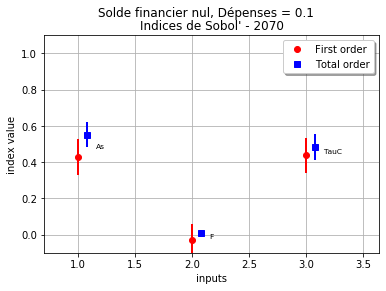

In [10]:
graph = sensitivityAnalysis.draw()
view = otv.View(graph)
pl.suptitle("Solde financier nul, Dépenses = %.1f" % (D));
pl.title("Indices de Sobol' - %d" % (annee));

On observe que, compte tenu des intervalles de confiance, on ne peut pas identifier d'interactions entre les variabels puisque les indices totaux sont proches des indices du premier ordre. De plus, on observe que le coefficient d'élasticité n'est pas très influent en 2070 : celui-ci pourrait être remplacé par une constante. En revanche, l'âge de départ et le taux de chômage sont des variables qui influencent à un niveau égal la variabilité du niveau de pension en 2070. 

## Indices de Sobol' en fonction de l'année

In [11]:
def calculeIndicesSobol(annee, S, D, size = 1000):
    """
    Calcule les indices de Sobol' pour une année donnée.
    
    Paramètres
    annee : un float, l'année
    S : le solde financier
    D : les dépenses de retraite (% PIB)
    sensitivityAnalysis : l'analyse de sensibilité
    
    """
    # Crée le modèle
    modele = ModelePensionProbabiliste(simulateur, annee, S, D)
    fonctionPension = modele.getFonction()
    inputDistribution = modele.getInputDistribution()
    # Calcule les indices de Sobol'
    computeSecondOrder = False
    sie = ot.SobolIndicesExperiment(inputDistribution, size, computeSecondOrder)
    inputDesign = sie.generate()
    outputDesign = fonctionPension(inputDesign)
    sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)
    return sensitivityAnalysis

In [12]:
table_annees = ot.Sample(range(2020,2071,5),1)
nbAnnees = len(table_annees)
firstOrderIndices = ot.Sample(nbAnnees,3)
firstOrderIndicesUpper = ot.Sample(nbAnnees,3)
firstOrderIndicesLower = ot.Sample(nbAnnees,3)
totalOrderIndices = ot.Sample(nbAnnees,3)
totalOrderIndicesUpper = ot.Sample(nbAnnees,3)
totalOrderIndicesLower = ot.Sample(nbAnnees,3)
S = 0.0
D = 0.14
for i in range(nbAnnees):
    a = table_annees[i,0]
    print(a)
    sensitivityAnalysis = calculeIndicesSobol(a, S, D)
    firstOrderIndices[i] = sensitivityAnalysis.getFirstOrderIndices()
    totalOrderIndices[i] = sensitivityAnalysis.getTotalOrderIndices()
    interval = sensitivityAnalysis.getFirstOrderIndicesInterval()
    firstOrderIndicesUpper[i] = interval.getUpperBound()
    firstOrderIndicesLower[i] = interval.getLowerBound()
    interval = sensitivityAnalysis.getTotalOrderIndicesInterval()
    totalOrderIndicesUpper[i] = interval.getUpperBound()
    totalOrderIndicesLower[i] = interval.getLowerBound()

2020.0
2025.0
2030.0
2035.0
2040.0
2045.0
2050.0
2055.0
2060.0
2065.0
2070.0


In [13]:
alpha = sensitivityAnalysis.getConfidenceLevel()
alpha

0.95

In [14]:
def setGraphBoundingBox(graph, xmin = None, xmax = None, ymin = None, ymax = None):
    """
    Set the bounding box in a graph with keywords.
    
    Parameters
    xmin : the x minimum value
    xmax : the x maximum value
    ymin : the y minimum value
    ymax : the y maximum value
    """
    boundingBox = graph.getBoundingBox()
    lb = boundingBox.getLowerBound()
    ub = boundingBox.getUpperBound()
    if xmin is not None:
        lb[0] = xmin
    if ymin is not None:
        lb[1] = ymin
    if xmax is not None:
        ub[0] = xmax
    if ymax is not None:
        ub[1] = ymax
    boundingBox.setLowerBound(lb)
    boundingBox.setUpperBound(ub)
    graph.setBoundingBox(boundingBox)
    return graph

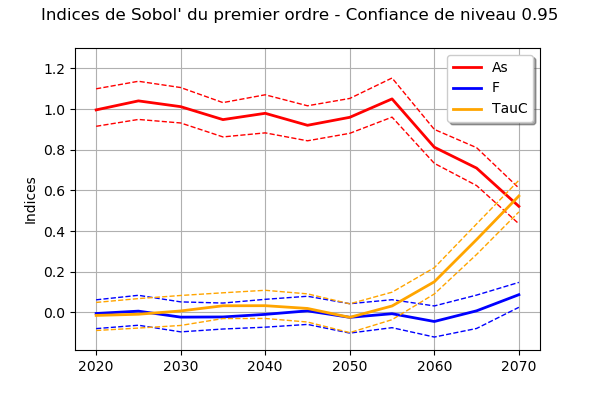

In [15]:
title = "Indices de Sobol' du premier ordre - Confiance de niveau %.2f" % (alpha)
xTitle = ""
yTitle = "Indices" 
showAxes = True
descriptions = inputDistribution.getDescription()
dim = inputDistribution.getDimension()
colors = ["red", "blue", "orange"]
graph = ot.Graph(title, xTitle, yTitle, showAxes)
for i in range(dim):
    curve = ot.Curve(table_annees, firstOrderIndices[:,i])
    curve.setColor(colors[i])
    curve.setLegend(descriptions[i])
    curve.setLineWidth(2)
    graph.add(curve)
    curve = ot.Curve(table_annees, firstOrderIndicesUpper[:,i])
    curve.setColor(colors[i])
    curve.setLineStyle("dashed")
    graph.add(curve)
    curve = ot.Curve(table_annees, firstOrderIndicesLower[:,i])
    curve.setColor(colors[i])
    curve.setLineStyle("dashed")
    graph.add(curve)
graph.setLegendPosition("topright")
graph = setGraphBoundingBox(graph, ymax = 1.3)
graph

Le graphique précédent représente la sensibilité du modèle aux trois variables probabilisées. Les lignes continues représentent les indices de sensibilité tandis que les lignes discontinues représentent l'intervalle de confiance de niveau 95%. 

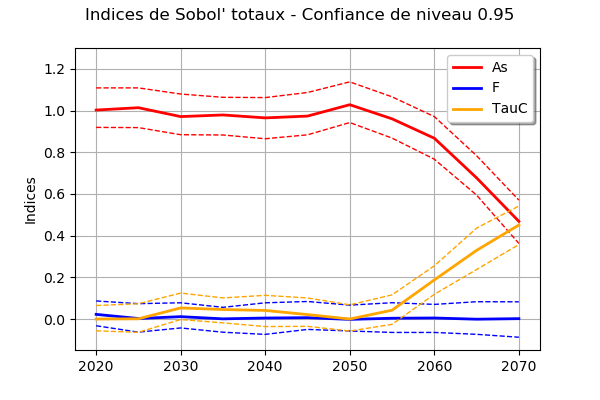

In [16]:
title = "Indices de Sobol' totaux - Confiance de niveau %.2f" % (alpha)
xTitle = ""
yTitle = "Indices" 
showAxes = True
descriptions = inputDistribution.getDescription()
dim = inputDistribution.getDimension()
colors = ["red", "blue", "orange"]
graph = ot.Graph(title, xTitle, yTitle, showAxes)
for i in range(dim):
    curve = ot.Curve(table_annees, totalOrderIndices[:,i])
    curve.setColor(colors[i])
    curve.setLegend(descriptions[i])
    curve.setLineWidth(2)
    graph.add(curve)
    curve = ot.Curve(table_annees, totalOrderIndicesUpper[:,i])
    curve.setColor(colors[i])
    curve.setLineStyle("dashed")
    graph.add(curve)
    curve = ot.Curve(table_annees, totalOrderIndicesLower[:,i])
    curve.setColor(colors[i])
    curve.setLineStyle("dashed")
    graph.add(curve)
graph.setLegendPosition("topright")
graph = setGraphBoundingBox(graph, ymax = 1.3)
graph

On observe que le coefficient d'élasticité de report de l'âge de départ en retraite n'est pas un paramètre influent, quelque soit l'année que l'on considère. L'âge de départ en retraite est le seul paramètre influent le niveau de pension jusqu'en 2050. L'influence du taux de chômage est négligeable jusqu'en 2050, puis devient croissant jusqu'en 2070. A cette date, le taux de chômage a une influence aussi marqué que l'âge de départ à la retraite. 